## Install Required Libraries

In [1]:
!pip install statsmodels

# 0. Import

In [2]:
# Basic
import numpy as np 
import pandas as pd

# Visalizaton
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprosessing
from datetime import date
import holidays
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# Models
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. Load Data

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/train-test-data/train_test_data.csv


In [4]:
# Load the dataset (assuming the file is correctly uploaded and named)
file_path = '/kaggle/input/train-test-data/train_test_data.csv'
data = pd.read_csv(file_path)

# 2. Basic Infromation from data


In [5]:
data.head()

,Date,Id_compte,amount_transaction,category_transaction
0,2022-01-01 00:23:00,SEWC_CL.1,462.96,Food & Drink - Groceries
1,2022-01-01 00:26:00,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance
2,2022-01-01 01:01:00,US.1,2.24,Bank Transfers - ATM withdrawals
3,2022-01-01 01:21:00,TA.1,2.86,Transportation - Public Transport
4,2022-01-01 01:54:00,US.1,1.68,Bank Transfers - ATM withdrawals


In [6]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

In [7]:
summary(data).style.background_gradient(cmap='Blues')

data shape: (20411, 4)


,data type,#missing,%missing,#unique,min,max
Date,object,0,0.000000,19984,nan,nan
Id_compte,object,0,0.000000,12,nan,nan
amount_transaction,float64,0,0.000000,176,0.230000,2005.200000
category_transaction,object,0,0.000000,68,nan,nan


In [8]:
print(data.duplicated().sum())
data = data.drop_duplicates()

2


In [9]:
duplicate_dates = data[data.duplicated('Date', keep=False)]

# Display duplicate dates
print("Duplicate Dates:")
print(duplicate_dates[['Date', 'amount_transaction']])

Duplicate Dates:
                      Date  amount_transaction
73     2022-01-02 06:53:00                3.10
74     2022-01-02 06:53:00                5.79
111    2022-01-02 22:35:00                1.43
112    2022-01-02 22:35:00                5.33
277    2022-01-05 18:11:00                2.33
...                    ...                 ...
20139  2022-11-02 18:59:00                0.23
20306  2022-11-05 14:38:00               17.41
20307  2022-11-05 14:38:00                1.43
20370  2022-11-06 14:34:00                0.31
20371  2022-11-06 14:34:00                1.12

[848 rows x 2 columns]


In [10]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')    


In [11]:
data = data.drop_duplicates('Date')

# 3. EDA

**Date column changes**

In [12]:
data['month']=data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week']=data['Date'].dt.day_of_week
data['year'] = data['Date'].dt.year
data['quarter'] = data['Date'].dt.quarter
data['weekofyear'] = data['Date'].dt.isocalendar().week 
data["dayofyear"] = data['Date'].dt.dayofyear
data["is_month_end"] = data["Date"].dt.is_month_end
data["is_month_start"] = data["Date"].dt.is_month_start
data["is_year_end"] = data["Date"].dt.is_year_end
data["is_year_start"] = data["Date"].dt.is_year_start
data['hour'] = data['Date'].dt.hour
data['minute'] = data['Date'].dt.minute

**amount_transaction per month**


In [13]:
# grouping by month to see amount_transaction
amount_month = data.groupby('month')['amount_transaction'].sum().reset_index() 
amount_month

,month,amount_transaction
0,1,112914.18
1,2,111756.28
2,3,107694.14
3,4,105947.26
4,5,111430.48
5,6,109594.31
6,7,117111.05
7,8,120831.21
8,9,109819.41
9,10,109579.54


Text(0.5, 1.0, 'Time series Graph for amount_transaction monthwise')

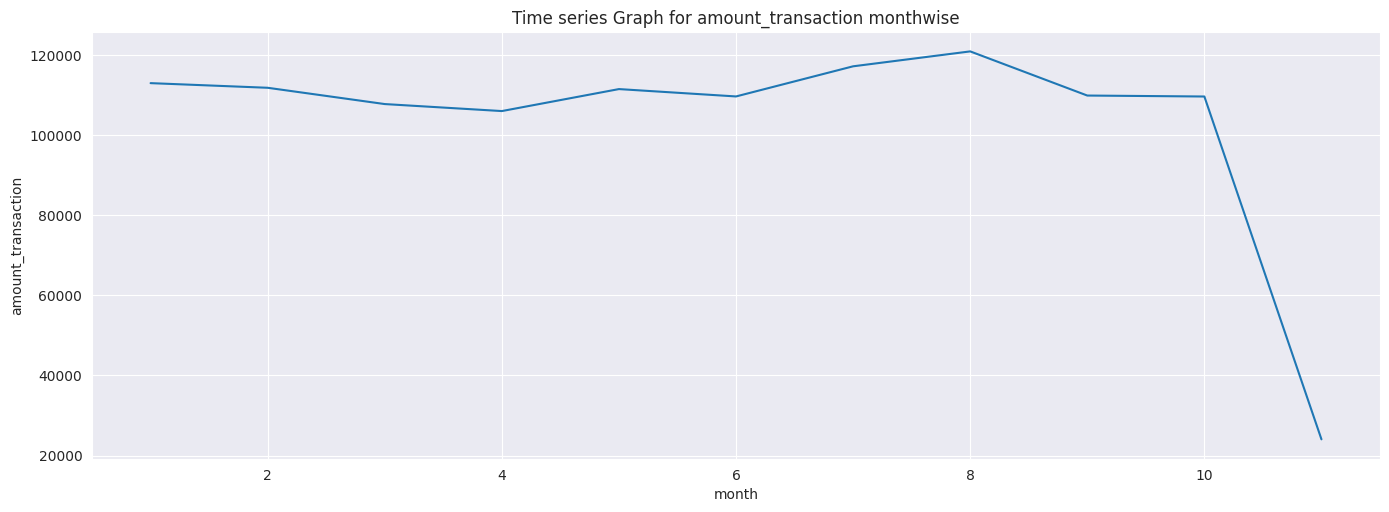

In [14]:
# plot for num_sold vs month
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.lineplot(data=amount_month,x='month',y='amount_transaction',markers='<')
plt.tight_layout()
plt.title('Time series Graph for amount_transaction monthwise')

**In the month N°11 the ammount of transactions declines sharply**

In [15]:
days = {0:'Monday',1:'Tuesday',3:'Thursday',2:'Wednesday',4: 'Friday',5:'Saturday',6:'Sunday'}
day = data.groupby('day_of_week')['amount_transaction'].sum().reset_index()
day['day_of_week'] = day['day_of_week'].map(days)
day

,day_of_week,amount_transaction
0,Monday,160299.53
1,Tuesday,148660.16
2,Wednesday,163286.37
3,Thursday,148620.38
4,Friday,161054.70
5,Saturday,189611.64
6,Sunday,169214.82


Text(0.5, 1.0, 'Time series Graph for amount_transaction day of week')

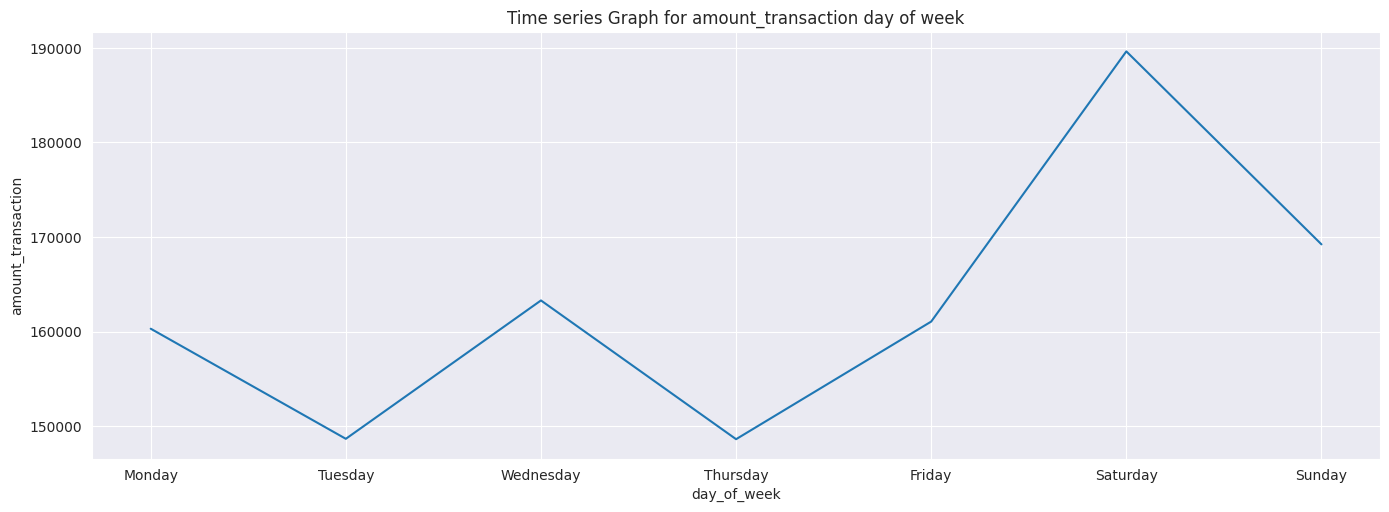

In [16]:
# plot for amount_transaction vs day_of_week
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.lineplot(data=day,x='day_of_week',y='amount_transaction',markers='<')
plt.tight_layout()
plt.title('Time series Graph for amount_transaction day of week')

**THERE IS A PEAK OF TRANSACTIONS IN SATRUDAY**

In [17]:
# grouping by minute to see amount_transaction
amount_minute = data.groupby('minute')['amount_transaction'].sum().reset_index() 

Text(0.5, 1.0, 'Time series Graph for amount_transaction monthwise')

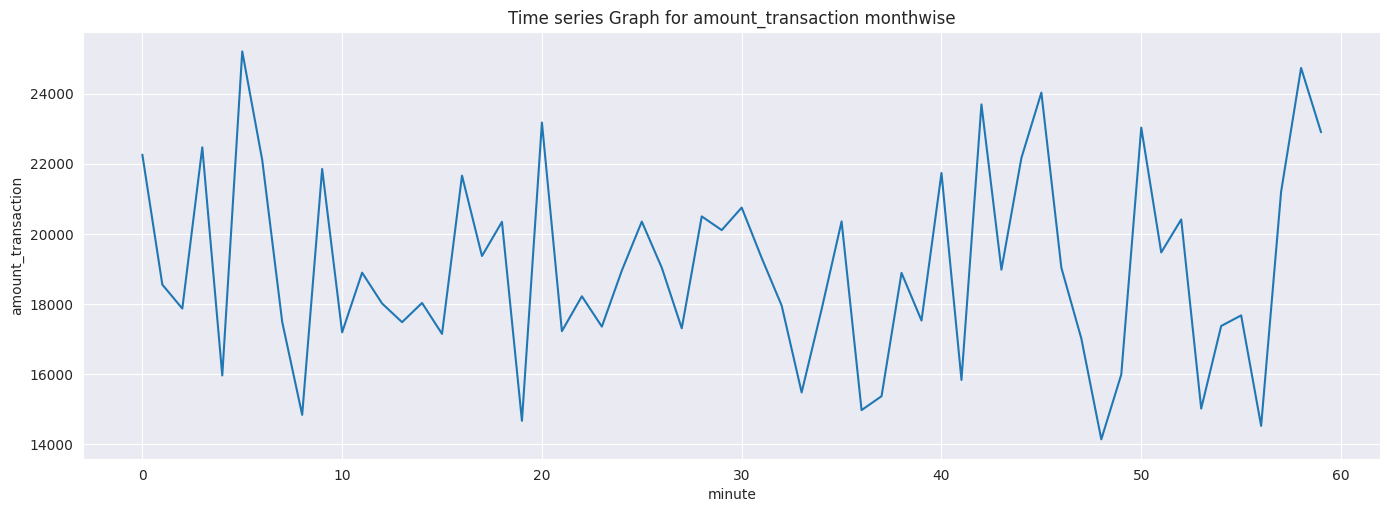

In [18]:
# plot for amount_transaction vs dayofyear
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.lineplot(data=amount_minute ,x='minute',y='amount_transaction',markers='<')
plt.tight_layout()
plt.title('Time series Graph for amount_transaction monthwise')

**AS WE CAN SEE THAT ARE CAHNGES IN PRICE FROM MINUTE TO ANOTHER**

In [19]:
# grouping by hour to see amount_transaction
amount_hour = data.groupby('hour')['amount_transaction'].sum().reset_index() 

Text(0.5, 1.0, 'Time series Graph for amount_transaction monthwise')

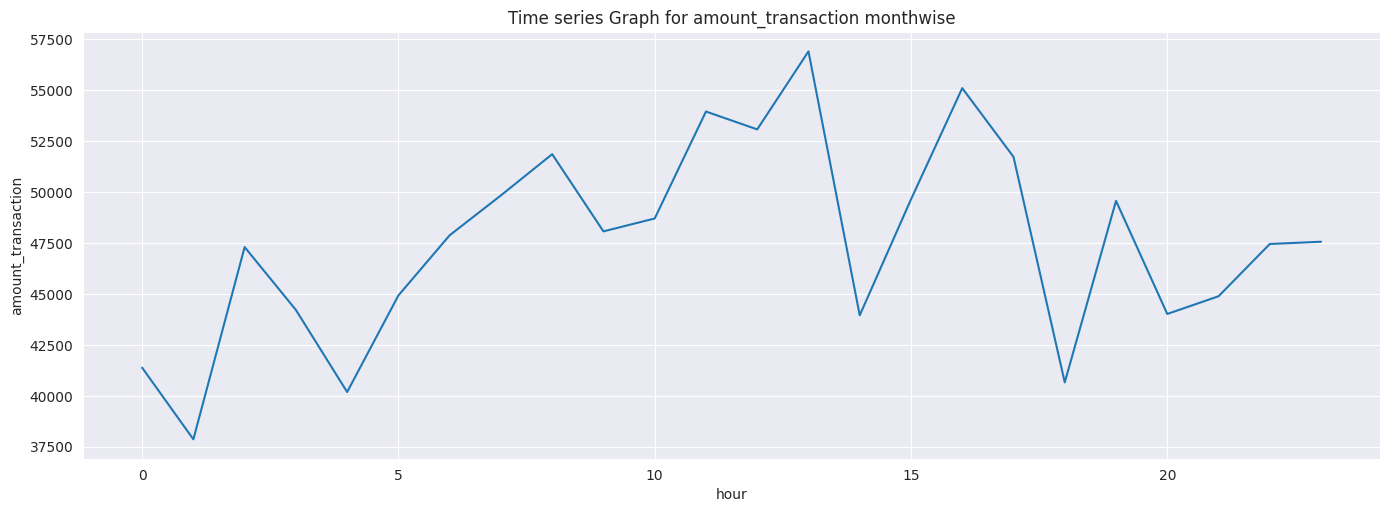

In [20]:
# plot for amount_transaction vs dayofyear
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.lineplot(data=amount_hour,x='hour',y='amount_transaction',markers='<')
plt.tight_layout()
plt.title('Time series Graph for amount_transaction monthwise')

In [21]:
print(data['category_transaction'].nunique())
print(data["Id_compte"].nunique())

68
12


In [22]:
data["category_transaction"].value_counts()

category_transaction
Bank Transfers - ATM fees                        3651
Transportation - Public Transport                3042
Transportation - Parking                         2513
Bank Transfers - ATM withdrawals                 2154
Food & Drink - Coffee and tea                    2116
                                                 ... 
Bank Transfers - Banking rewards                    2
Government + Non-Profit - Political donations       2
General Merchandise  - Product refunds              2
Government + Non-Profit - Other donations           1
Government + Non-Profit - Other                     1
Name: count, Length: 68, dtype: int64

In [23]:
n = data["category_transaction"].value_counts()
categories = n[n < 20]
print(categories)

category_transaction
Loans - Mortgage payments                        10
General Services  - Cloud storage                 9
Loans - Car loan payments                         9
General Services  - Education                     8
General Merchandise - Online Marketplaces         8
General Services - Health insurance               8
General Services  - Other Insurance               8
Loans - Personal loans                            8
Credit card payment                               7
Travel  - Rental cars                             7
Entertainment  - Casinos and gambling             7
General Services  - Shipping + Postage            6
Government + Non-Profit - Taxes                   5
Income - Tax refund                               5
General Services - Auto insurance                 4
General Services  - Service refunds               3
Bank Transfers - Banking rewards                  2
Government + Non-Profit - Political donations     2
General Merchandise  - Product refunds     

In [24]:
count = data.groupby('Id_compte')['amount_transaction'].sum().reset_index()
count

,Id_compte,amount_transaction
0,CPA.1,56318.08
1,CPA_MP.1,78800.83
2,HP.1,73905.75
3,IPA.1,123446.99
4,SEW0C_HI.1,101817.00
5,SEW0C_LI.1,45550.02
6,SEWC_CL.1,134798.76
7,SEWC_P.1,172104.08
8,SEWC_PA.1,146392.60
9,SEWC_P_PL.1,121971.19


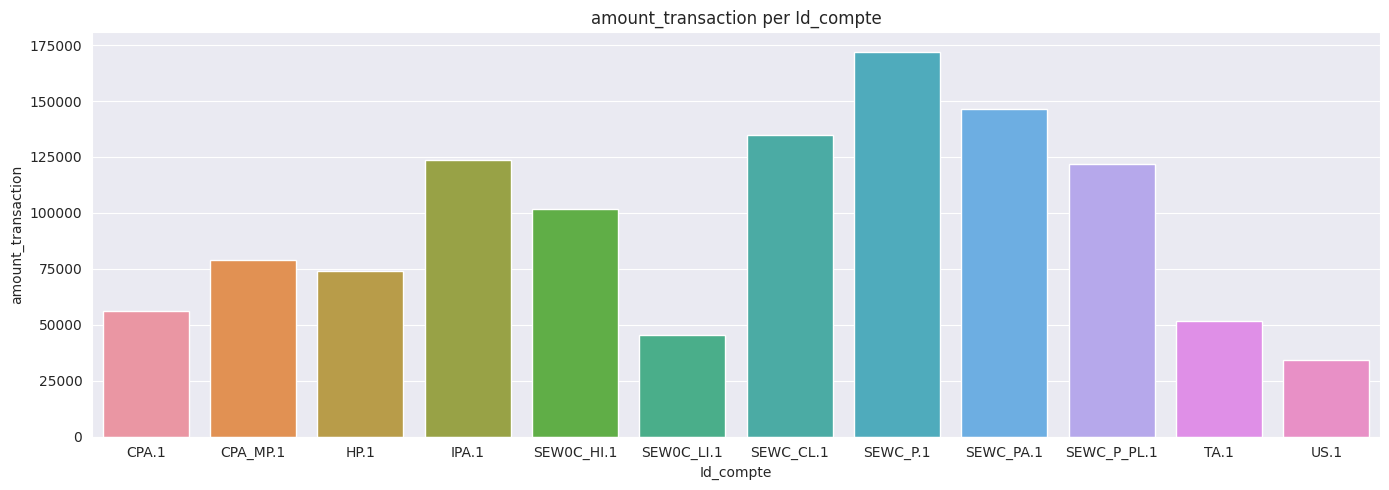

In [25]:
plt.figure(figsize=(14,5))
sns.barplot(data = count, x='Id_compte', y='amount_transaction')
plt.title('amount_transaction per Id_compte')
plt.tight_layout()

Now that we know the column type we can devide the columns into categorical columns(cat_cols) and numerical ones(num_cols)

In [26]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
num_cols = [col for col in data.columns if data[col].dtype != 'object']

In [27]:
num_transactions = ( data['amount_transaction'] <= 10).sum()
print("Number of transactions with amount less than 10:", num_transactions)

num_transactions = (data['amount_transaction'] >= 10) .sum()
print("Number of transactions with amount greater than 10:", num_transactions)

Number of transactions with amount less than 10: 15299
Number of transactions with amount greater than 10: 4685


The is another way to display the insights we get from the histogram
As it shows the number of transactions with amount less than 10 is more than 3 times greater than the number of transactions with amount greater than 10 (Probable data outliers)

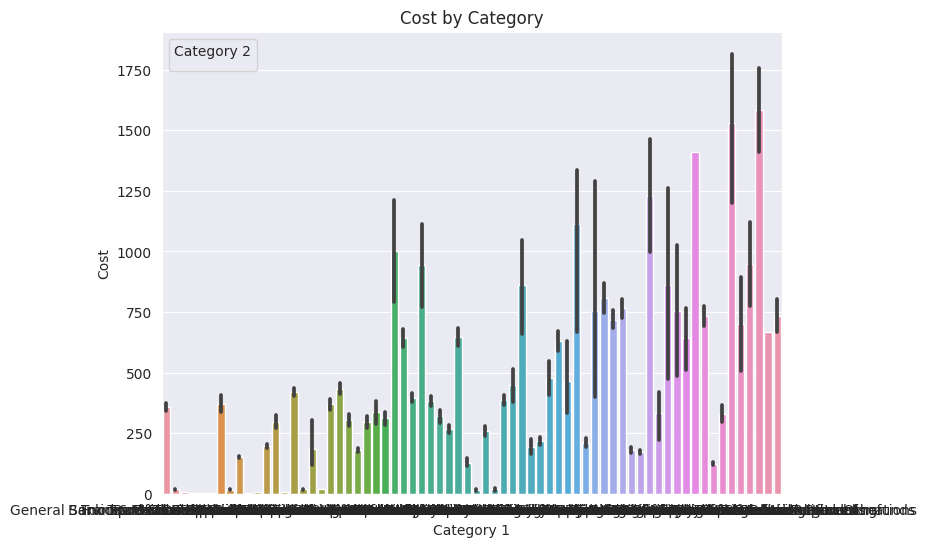

In [28]:
plt.figure(figsize=(8, 6))
sns.barplot(x='category_transaction', y='amount_transaction', data=data)
plt.xlabel('Category 1')
plt.ylabel('Cost')
plt.title('Cost by Category')
plt.legend(title='Category 2')
plt.show()

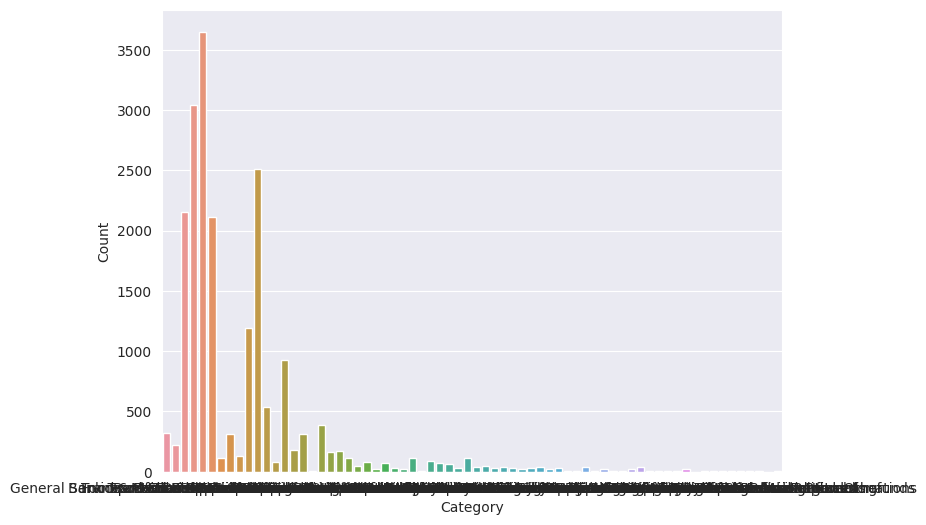

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(x='category_transaction', data=data)
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

## Correlation

In [30]:
def correlation_plot(data=None, variables=None):
    corr_matrix = data[variables].corr()
    fig, axes = plt.subplots(figsize=(20, 12), ncols=1)
    sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9}, ax=axes, cbar=False)
    axes.set_title('DataSet', fontsize=15)

    plt.suptitle('Correlation Matrices of dataSet', fontsize=25, weight='bold')

    plt.show()

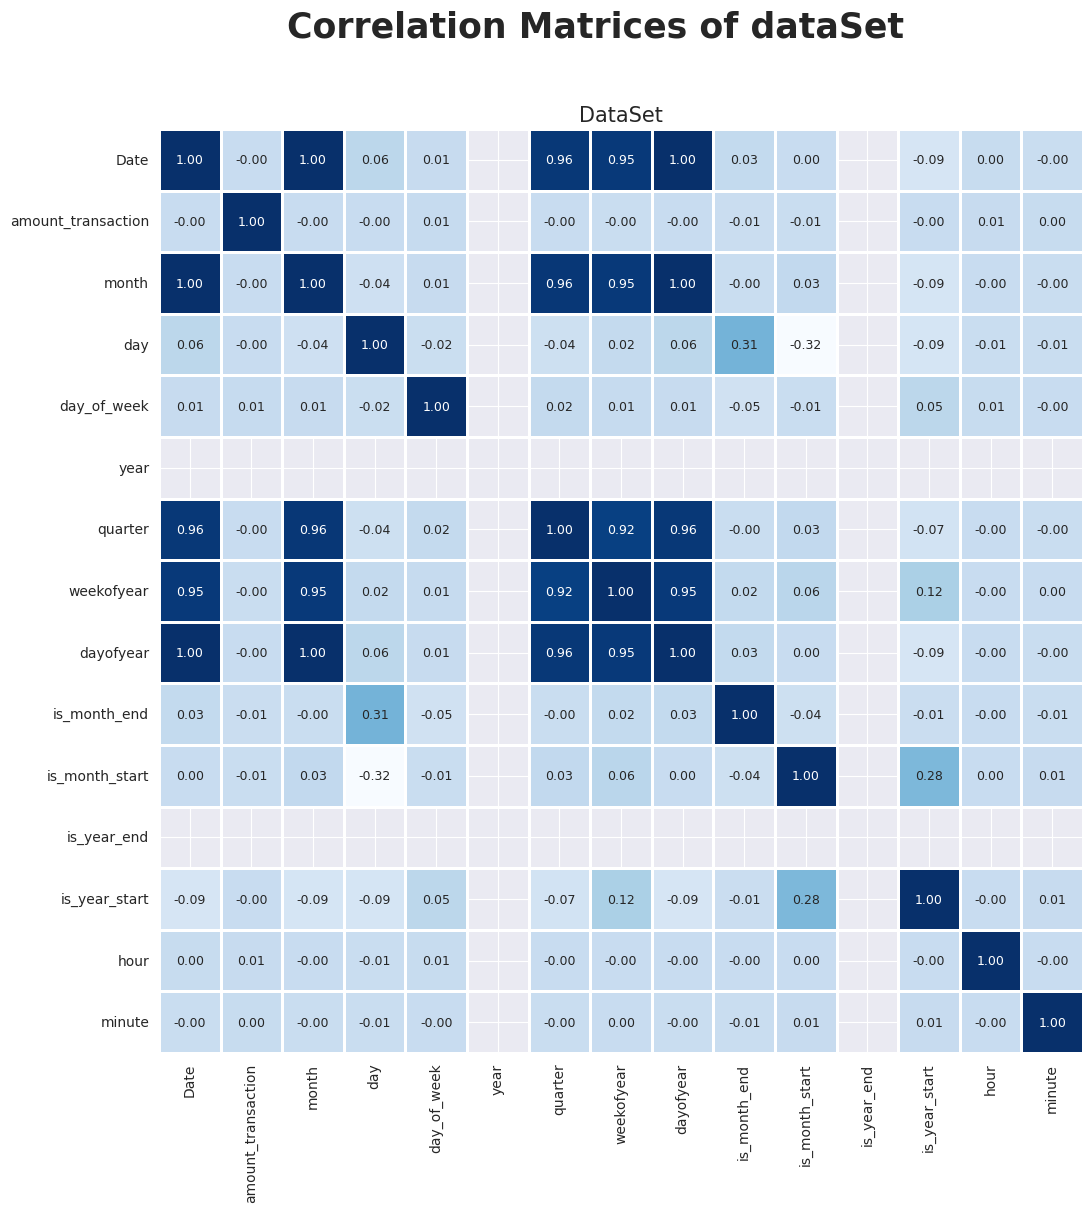

In [31]:
correlation_plot(data=data,variables=num_cols)

In [32]:
def search_high_corr_pairs(data_set = None, variables =None, threshold = 0.8):
    corr_matrix=data_set[variables].corr()
    high_corr_pairs=[]
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1,len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                print(f'\033[91m{corr_matrix.columns[i]}\033[0m and \033[91m{corr_matrix.columns[j]}\033[0m are highly linearly correlated, indicating the possibility of collinearity.')
                high_corr_pairs.append((corr_matrix.columns[i],corr_matrix.columns[j]))
    if len(high_corr_pairs) == 0:
        print(f'All variables are not linearly related.')
    return high_corr_pairs

In [33]:
high_corr_pairs = search_high_corr_pairs(data_set=data, variables=num_cols)

Date and month are highly linearly correlated, indicating the possibility of collinearity.
Date and quarter are highly linearly correlated, indicating the possibility of collinearity.
Date and weekofyear are highly linearly correlated, indicating the possibility of collinearity.
Date and dayofyear are highly linearly correlated, indicating the possibility of collinearity.
month and quarter are highly linearly correlated, indicating the possibility of collinearity.
month and weekofyear are highly linearly correlated, indicating the possibility of collinearity.
month and dayofyear are highly linearly correlated, indicating the possibility of collinearity.
quarter and weekofyear are highly linearly correlated, indicating the possibility of collinearity.
quarter and dayofyear are highly linearly correlated, indicating the possibility of collinearity.
weekofyear and dayofyear are highly linearly correlated, indicating the possibility of collinearity.


In [34]:
# We can drop the corrolated columns


# columns_to_drop = ['quarter', 'weekofyear', 'dayofyear']
# data = data.drop(columns=columns_to_drop, errors='ignore')

# checking for outliers

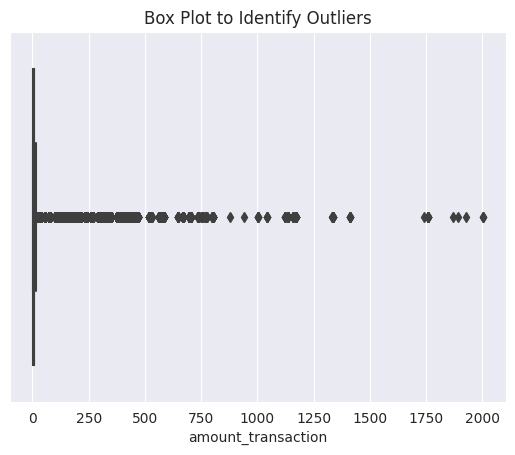

In [35]:
sns.boxplot(x=data['amount_transaction'])
plt.xlabel('amount_transaction')
plt.title('Box Plot to Identify Outliers')
plt.show()

The plot is unclear so we need to do it ourselves and find them using the IQR method.

In [36]:
amount_data = data['amount_transaction']

Q1 = np.percentile(amount_data, 25)
Q3 = np.percentile(amount_data, 75)

IQR = Q3 - Q1

upper_bound = Q3 + 1.2 * IQR

outliers = amount_data > upper_bound

print("Outliers:", np.sum(outliers))

Outliers: 3812


In [37]:
outliers

0         True
1        False
2        False
3        False
4        False
         ...  
20406     True
20407    False
20408    False
20409     True
20410    False
Name: amount_transaction, Length: 19984, dtype: bool

In [38]:
data_mean = data.copy()

In [39]:
data_mean.loc[outliers, 'amount_transaction'] = np.nan
grouped_means_without_outliers = data_mean.groupby('Id_compte')['amount_transaction'].mean()
data_mean['amount_transaction'] = data_mean['amount_transaction'].fillna(data_mean['Id_compte'].map(grouped_means_without_outliers))


In [40]:
data_mean

,Date,Id_compte,amount_transaction,category_transaction,month,day,day_of_week,year,quarter,weekofyear,dayofyear,is_month_end,is_month_start,is_year_end,is_year_start,hour,minute
0,2022-01-01 00:23:00,SEWC_CL.1,5.251981,Food & Drink - Groceries,1,1,5,2022,1,52,1,False,True,False,True,0,23
1,2022-01-01 00:26:00,SEW0C_LI.1,15.510000,General Services - Home Repair + Maintenance,1,1,5,2022,1,52,1,False,True,False,True,0,26
2,2022-01-01 01:01:00,US.1,2.240000,Bank Transfers - ATM withdrawals,1,1,5,2022,1,52,1,False,True,False,True,1,1
3,2022-01-01 01:21:00,TA.1,2.860000,Transportation - Public Transport,1,1,5,2022,1,52,1,False,True,False,True,1,21
4,2022-01-01 01:54:00,US.1,1.680000,Bank Transfers - ATM withdrawals,1,1,5,2022,1,52,1,False,True,False,True,1,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,2022-11-07 05:42:00,SEWC_P.1,5.191324,Medical - Pharmacies and supplements,11,7,0,2022,4,45,311,False,False,False,False,5,42
20407,2022-11-07 05:56:00,SEWC_CL.1,4.630000,Bank Transfers - ATM fees,11,7,0,2022,4,45,311,False,False,False,False,5,56
20408,2022-11-07 06:36:00,SEWC_PA.1,6.960000,Transportation - Parking,11,7,0,2022,4,45,311,False,False,False,False,6,36
20409,2022-11-07 06:37:00,SEW0C_HI.1,4.649436,Subscription - Others,11,7,0,2022,4,45,311,False,False,False,False,6,37


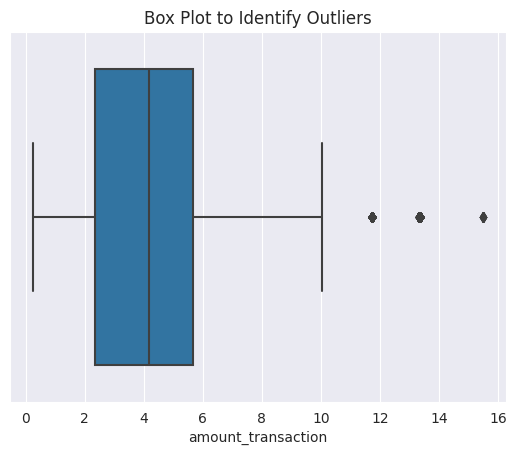

In [41]:
sns.boxplot(x=data_mean['amount_transaction'])
plt.xlabel('amount_transaction')
plt.title('Box Plot to Identify Outliers')
plt.show()

**ANOTHER SOLUTION**
Let's see if there is any outliers if we only take the (amount_transaction<10)
**NB: removing rows may result in deleting some categorical values**

In [42]:
newdata= data.copy()
newdata = newdata[newdata['amount_transaction'] < 10]

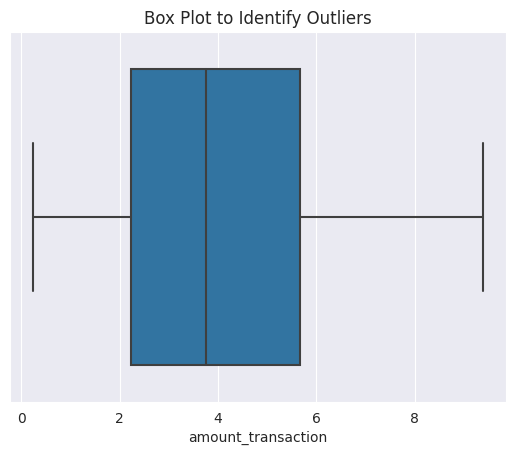

In [43]:
sns.boxplot(x=newdata['amount_transaction'])
plt.xlabel('amount_transaction')
plt.title('Box Plot to Identify Outliers')
plt.show()

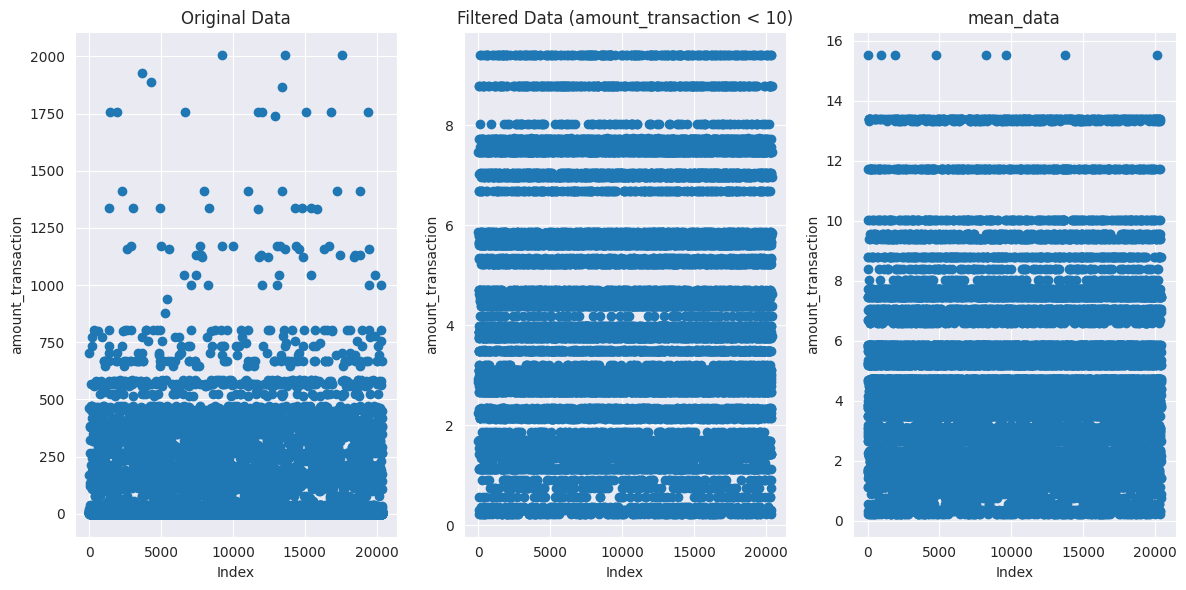

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].scatter(x=data.index, y=data['amount_transaction'])
axs[0].set_title('Original Data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('amount_transaction')

axs[1].scatter(x=newdata.index, y=newdata['amount_transaction'])
axs[1].set_title('Filtered Data (amount_transaction < 10)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('amount_transaction')

axs[2].scatter(x=data_mean.index, y=data_mean['amount_transaction'])
axs[2].set_title('mean_data')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('amount_transaction')

plt.tight_layout()

# Show the plots
plt.show()

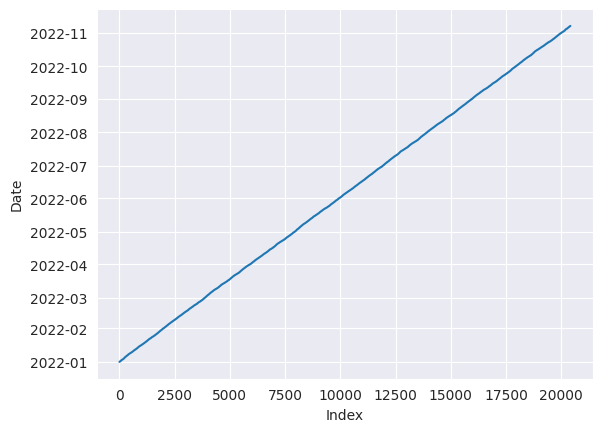

In [45]:
plt.plot(data_mean.index, data_mean['Date'])
plt.xlabel('Index')
plt.ylabel('Date')
plt.show()

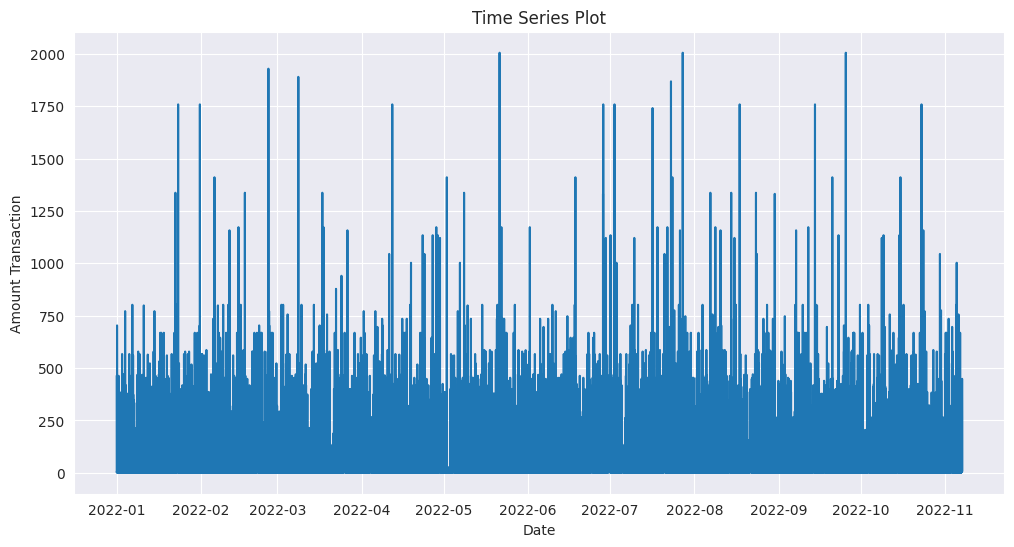

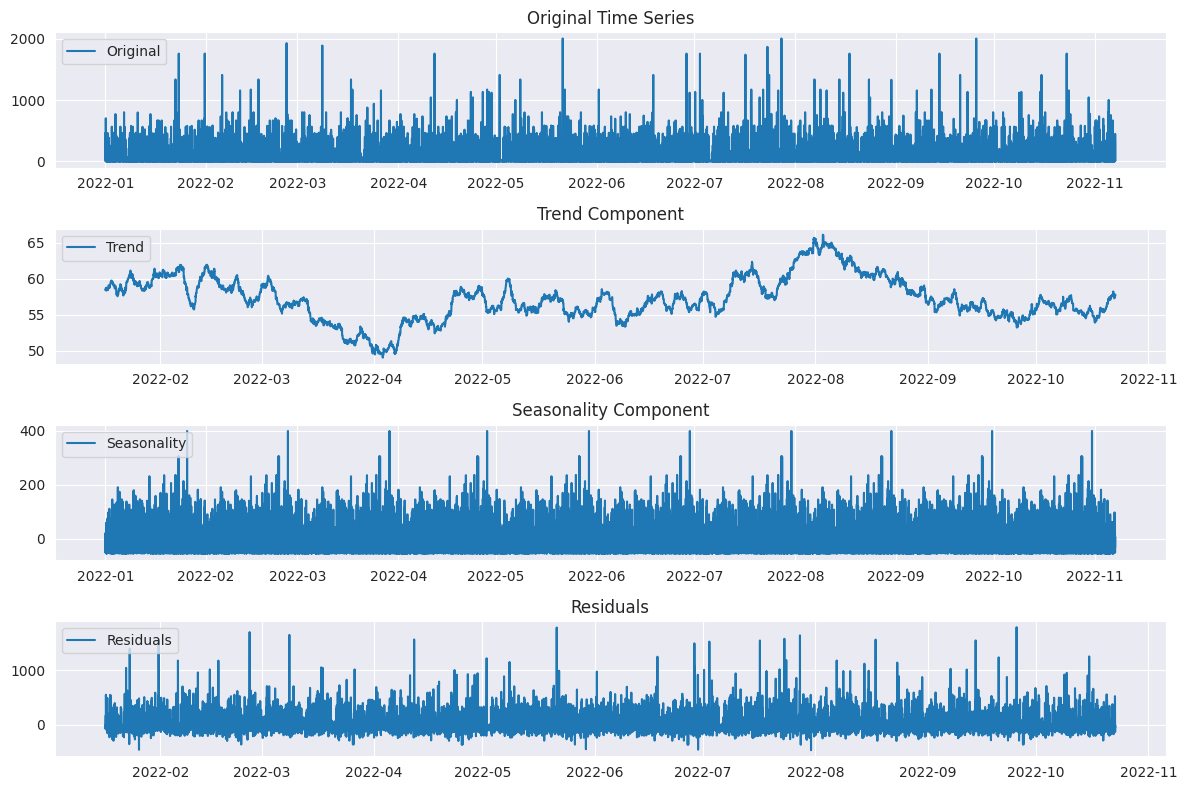

In [46]:
saison = data[['Date', 'amount_transaction']].copy()
saison['Date'] = pd.to_datetime(saison['Date'])
saison.set_index('Date', inplace=True)

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(saison['amount_transaction'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Amount Transaction')
plt.show()

# Decompose the time series into trend, seasonality, and residual components
decomposition = sm.tsa.seasonal_decompose(saison['amount_transaction'], model='additive', period=1992)#1992 data points = approximatly every month
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(saison['amount_transaction'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonality Component')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.title('Residuals')
plt.tight_layout()

plt.show()

**We notice a potential seasonality every month** \
We can address that in the preprocessing \
We can also remove trends

In [47]:
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data = data.drop(columns=['month'])

## Stationarity

In [48]:
time_series = data.copy()
time_series.set_index('Date', inplace=True)

In [49]:
result = adfuller(time_series['amount_transaction'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely not stationary.")

ADF Statistic: -17.572296073910973
p-value: 4.045796625737604e-30
The time series is likely stationary.


## Autocorrolation

In [50]:

# Assuming 'data' is your time series data
dw_statistic = durbin_watson(data['amount_transaction'])

# Interpret the results
if dw_statistic < 2:
    print(f"Positive autocorrelation. Durbin-Watson statistic: {dw_statistic}")
elif dw_statistic > 2:
    print(f"Negative autocorrelation. Durbin-Watson statistic: {dw_statistic}")
else:
    print(f"No significant autocorrelation. Durbin-Watson statistic: {dw_statistic}")


Positive autocorrelation. Durbin-Watson statistic: 1.7615096905312444


# 4. Preprocessing

In [51]:
le = LabelEncoder()
data['Id_compte_encoded'] = le.fit_transform(data['Id_compte'])

In [52]:
lencoder = LabelEncoder()
data['category_transaction'] = lencoder.fit_transform(data['category_transaction'])

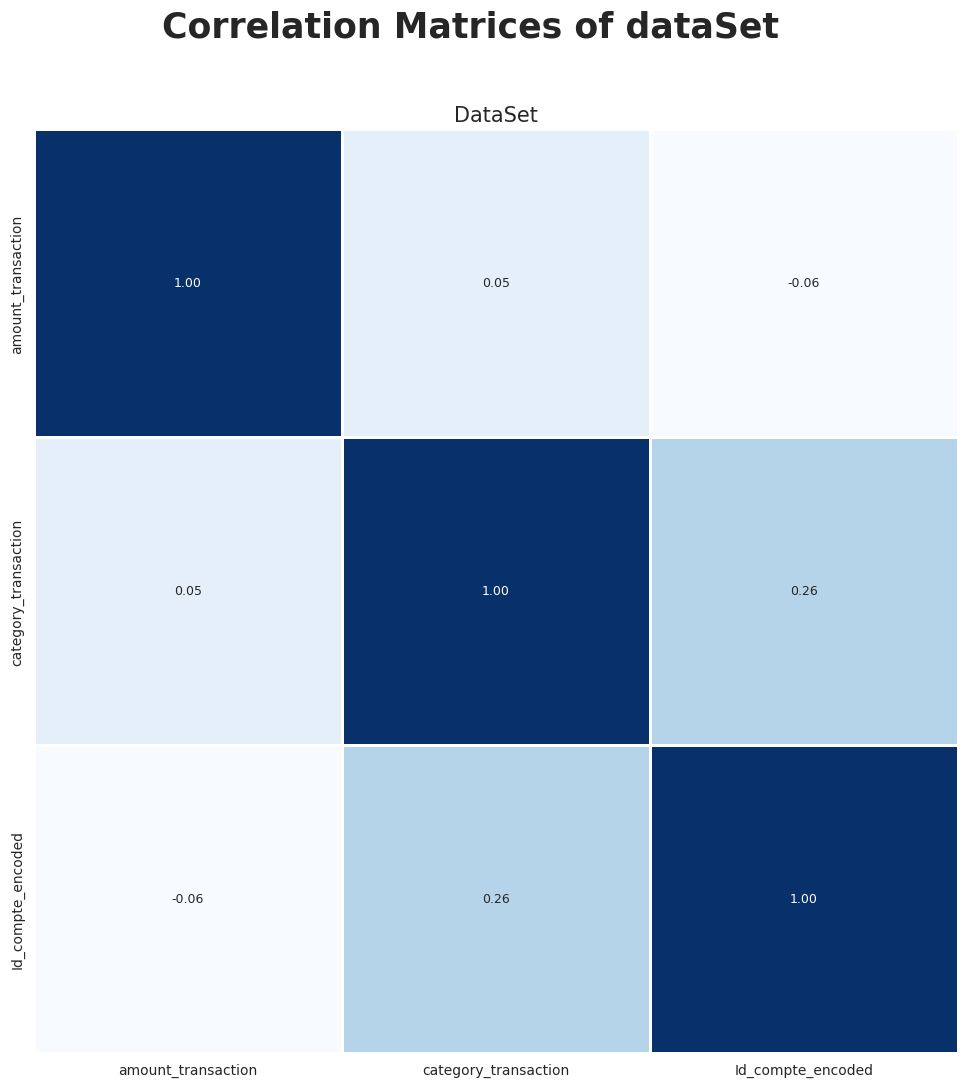

In [53]:
correlation_plot(data=data,variables=['amount_transaction','category_transaction','Id_compte_encoded'])

# 4. Modeling

In [54]:
split_date = data['Date'].quantile(0.7)  # Using the 80th percentile date for splitting
train_data = data[data['Date'] <= split_date]
test_data = data[data['Date'] > split_date]

# Data Preprocessing
# Dropping columns not used in the model
train_data = train_data.drop(columns=['category_transaction'])
test_data = test_data.drop(columns=['category_transaction'])

# Extracting year, month, and day as features
train_data['day'] = train_data['Date'].dt.day
train_data['day_of_week'] = train_data['Date'].dt.dayofweek
train_data['year'] = train_data['Date'].dt.year
train_data["is_month_end"] = train_data["Date"].dt.is_month_end
train_data["is_month_start"] = train_data["Date"].dt.is_month_start
train_data["is_year_end"] = train_data["Date"].dt.is_year_end
train_data["is_year_start"] = train_data["Date"].dt.is_year_start
train_data['hour'] = train_data['Date'].dt.hour
train_data['minute'] = train_data['Date'].dt.minute



test_data['day'] = test_data['Date'].dt.day
test_data['day_of_week'] = test_data['Date'].dt.dayofweek
test_data['year'] = test_data['Date'].dt.year
test_data["is_month_end"] = test_data["Date"].dt.is_month_end
test_data["is_month_start"] = test_data["Date"].dt.is_month_start
test_data["is_year_end"] = test_data["Date"].dt.is_year_end
test_data["is_year_start"] = test_data["Date"].dt.is_year_start
test_data['hour'] = test_data['Date'].dt.hour
test_data['minute'] = test_data['Date'].dt.minute


# Preparing the data for the model
X_train = train_data[['Id_compte_encoded', 'year', 'month_sin','month_cos', 'day','is_month_end','is_month_start','is_year_end','is_year_start','hour','minute']]
y_train = train_data['amount_transaction']

X_test = test_data[['Id_compte_encoded','year', 'month_sin','month_cos', 'day','is_month_end','is_month_start','is_year_end','is_year_start','hour','minute']]
y_test = test_data['amount_transaction']

# Model Development
# Using Linear Regression
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mse

26977.695160407777

Text(0.5, 1.0, 'Time series Graph for amount_transaction monthwise')

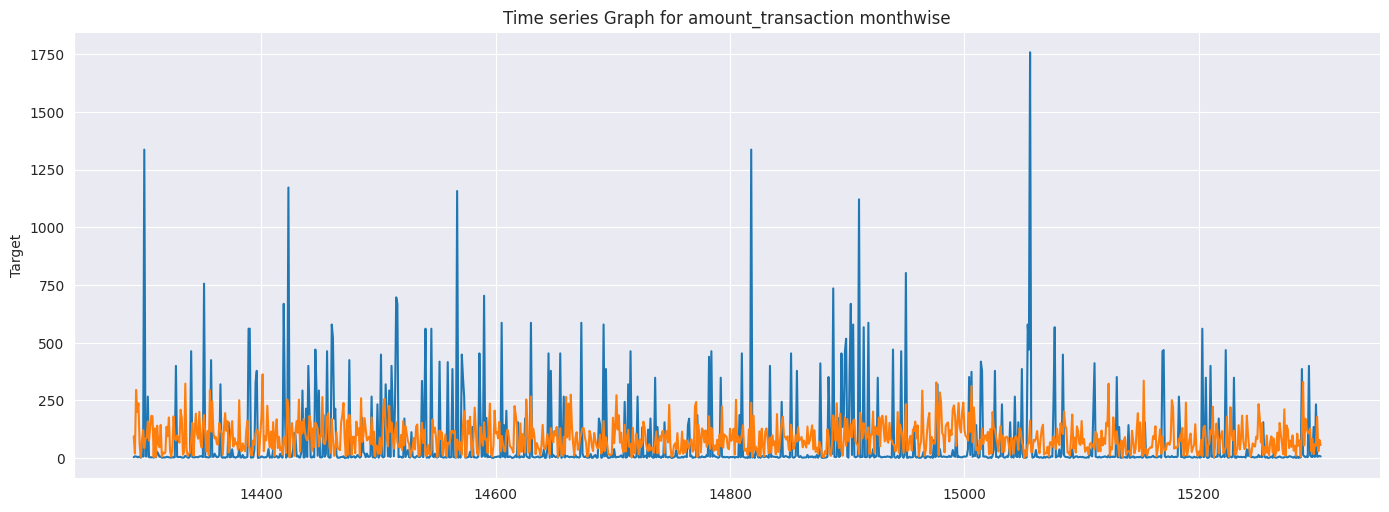

In [55]:
vis = pd.DataFrame({"Target": y_test[0:1000], "Predicted": y_pred[0:1000]})

# Create the plot
# plt.figure(figsize=(10, 6))
# plt.plot(vis.index, vis["Target"], '-o', label="Target", markersize=5)
# plt.plot(vis.index, vis["Predicted"], '-o', label="Predicted", markersize=5)
# plt.xlabel("Index")
# plt.ylabel("Amount Transaction")
# plt.title("Target vs. Predicted Transaction Amounts")
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.lineplot(data=vis,x=vis.index,y="Target",markers='<')
sns.lineplot(data=vis,x=vis.index,y="Predicted",markers='>')
plt.tight_layout()
plt.title('Time series Graph for amount_transaction monthwise')

In [56]:
# Generating Predictions for the Evaluation Period
# Creating a dataframe for prediction dates
prediction_dates = pd.date_range(start='2022-11-08', end='2022-12-31')
prediction_data = pd.DataFrame({
    'Date': np.repeat(prediction_dates, len(le.classes_)),
    'Id_compte_encoded': np.tile(le.transform(le.classes_), len(prediction_dates))
})

# Extracting month and day for prediction
prediction_data['month_sin'] = np.sin(2 * np.pi * prediction_data['Date'].dt.month / 12)
prediction_data['month_cos'] = np.cos(2 * np.pi * prediction_data['Date'].dt.month / 12)

prediction_data['year'] = prediction_data['Date'].dt.year
prediction_data['day'] = prediction_data['Date'].dt.day
prediction_data["is_month_end"] = prediction_data["Date"].dt.is_month_end
prediction_data["is_month_start"] = prediction_data["Date"].dt.is_month_start
prediction_data["is_year_end"] = prediction_data["Date"].dt.is_year_end
prediction_data["is_year_start"] = prediction_data["Date"].dt.is_year_start
prediction_data['hour'] = prediction_data['Date'].dt.hour
prediction_data['minute'] = prediction_data['Date'].dt.minute
# Making predictions
X_prediction = prediction_data[['Id_compte_encoded', 'year', 'month_sin','month_cos', 'day','is_month_end','is_month_start','is_year_end','is_year_start','hour','minute']]
predicted_amounts = model.predict(X_prediction)

# Adding the predicted amounts to the prediction data
prediction_data['Predicted_Amount'] = predicted_amounts

# Creating an ID column for output
prediction_data['ID'] = prediction_data['Date'].dt.strftime('%Y-%m-%d') + '_' + le.inverse_transform(prediction_data['Id_compte_encoded'])

# Preparing the final output
final_output = prediction_data[['ID', 'Predicted_Amount']]

# Save the final output data to a CSV file
final_output.to_csv('final_output_predictions.csv', index=False)